In [74]:
import pandas as pd  # importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['figure.dpi'] = 250
sns.set_style('darkgrid')
%matplotlib inline
from statsmodels.tsa.stattools import adfuller

In [75]:
df = pd.read_csv('exchange_rate.csv',index_col = 0, parse_dates=['date'])
   # reading csvfile.

#eda and preprocessing

In [76]:
df


,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


<Axes: xlabel='date'>

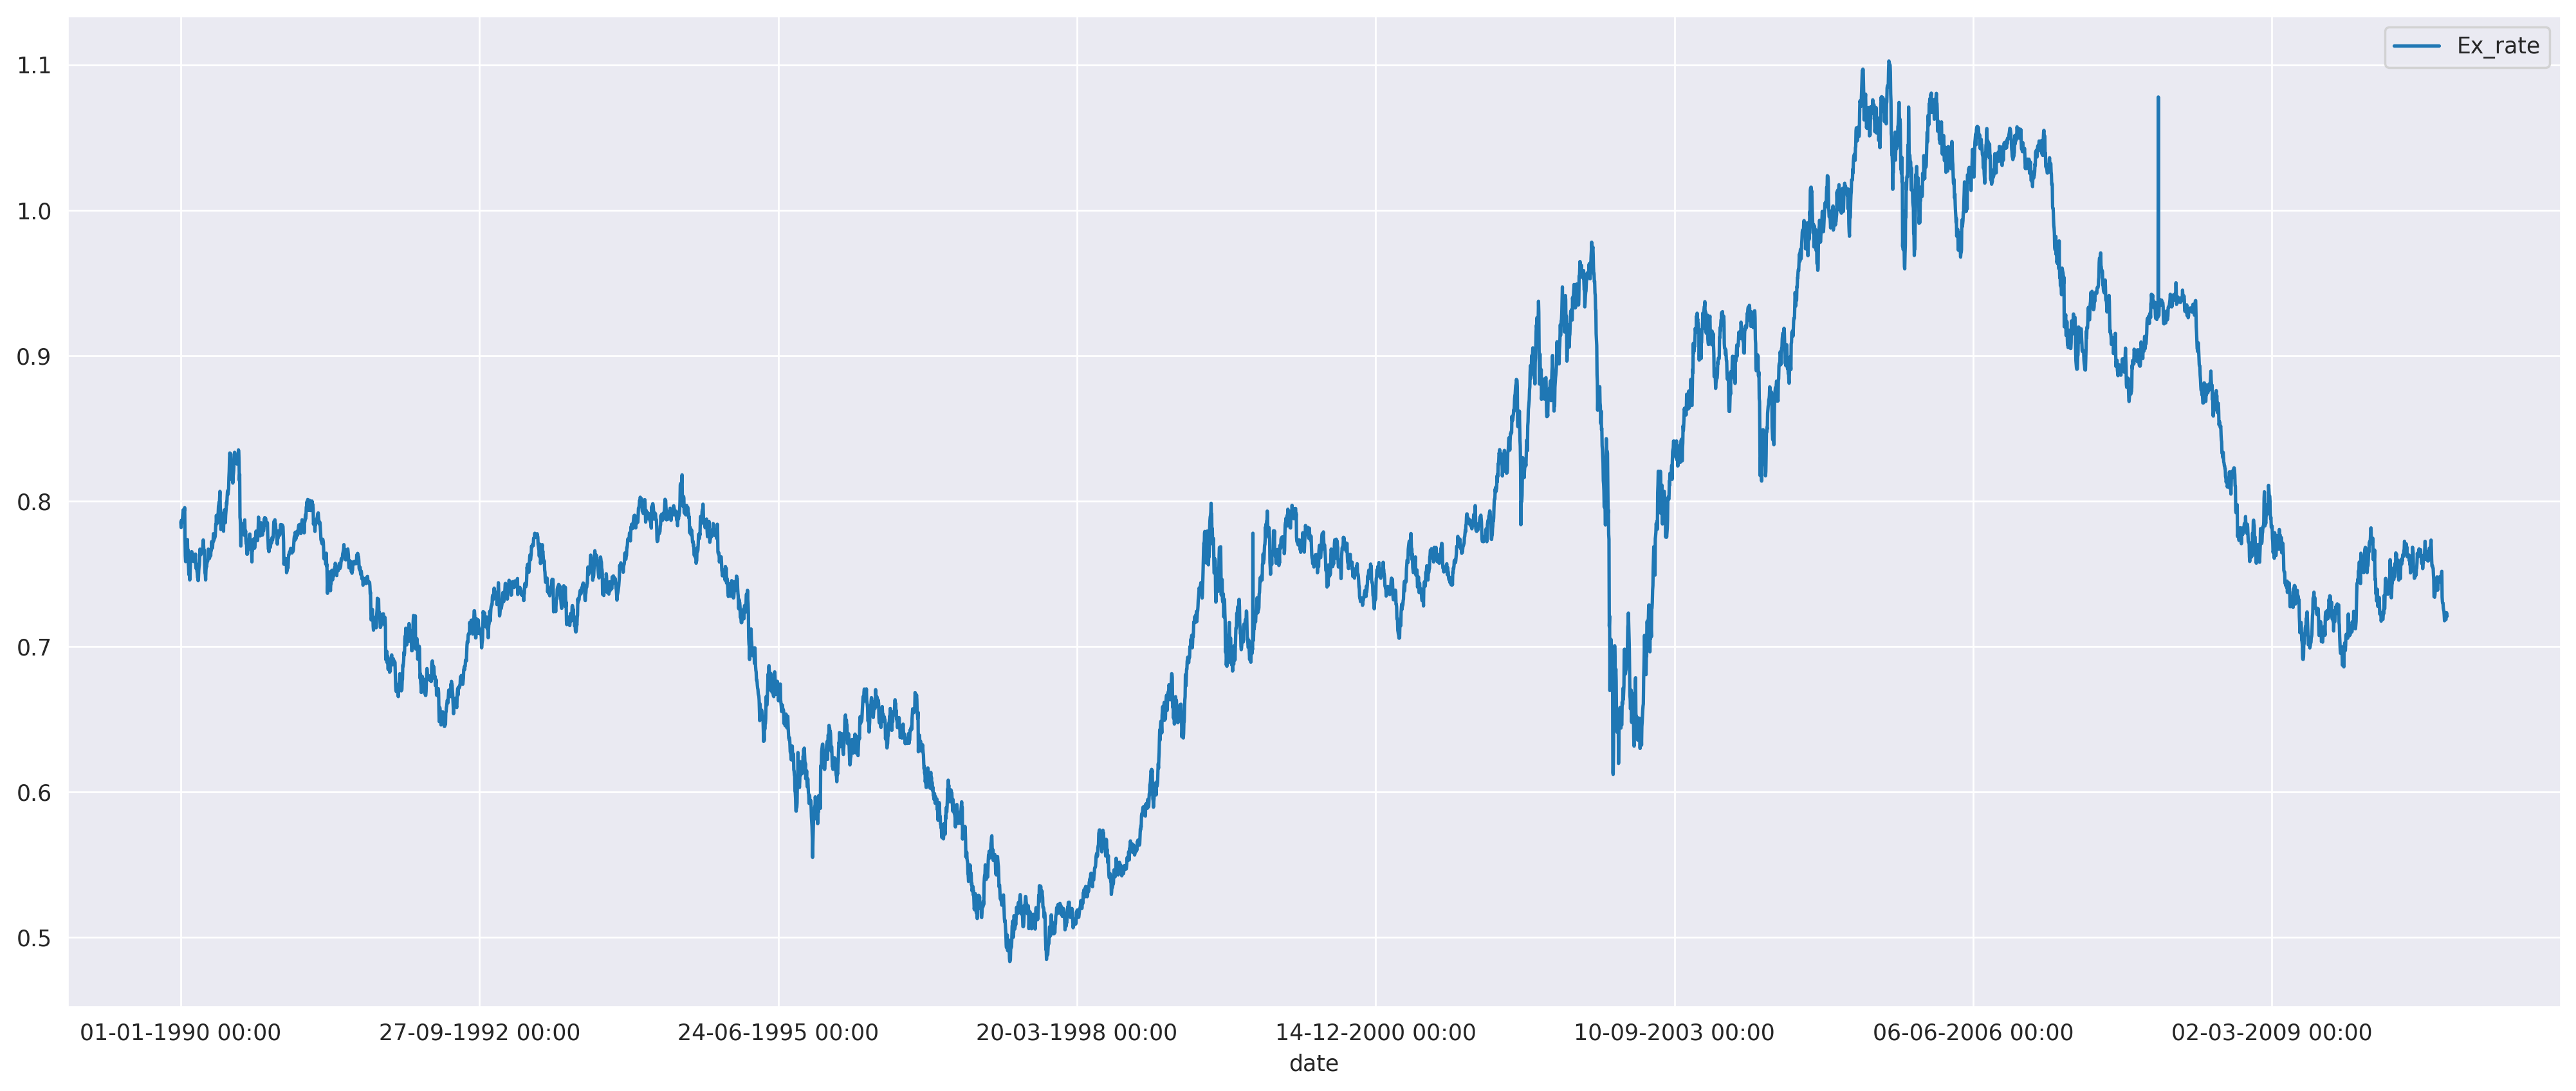

In [77]:
df.plot()

In [78]:
#missing values

In [79]:
df.isna().sum()

,0
Ex_rate,0


In [80]:
# no missing values

#Model Building - ARIMA

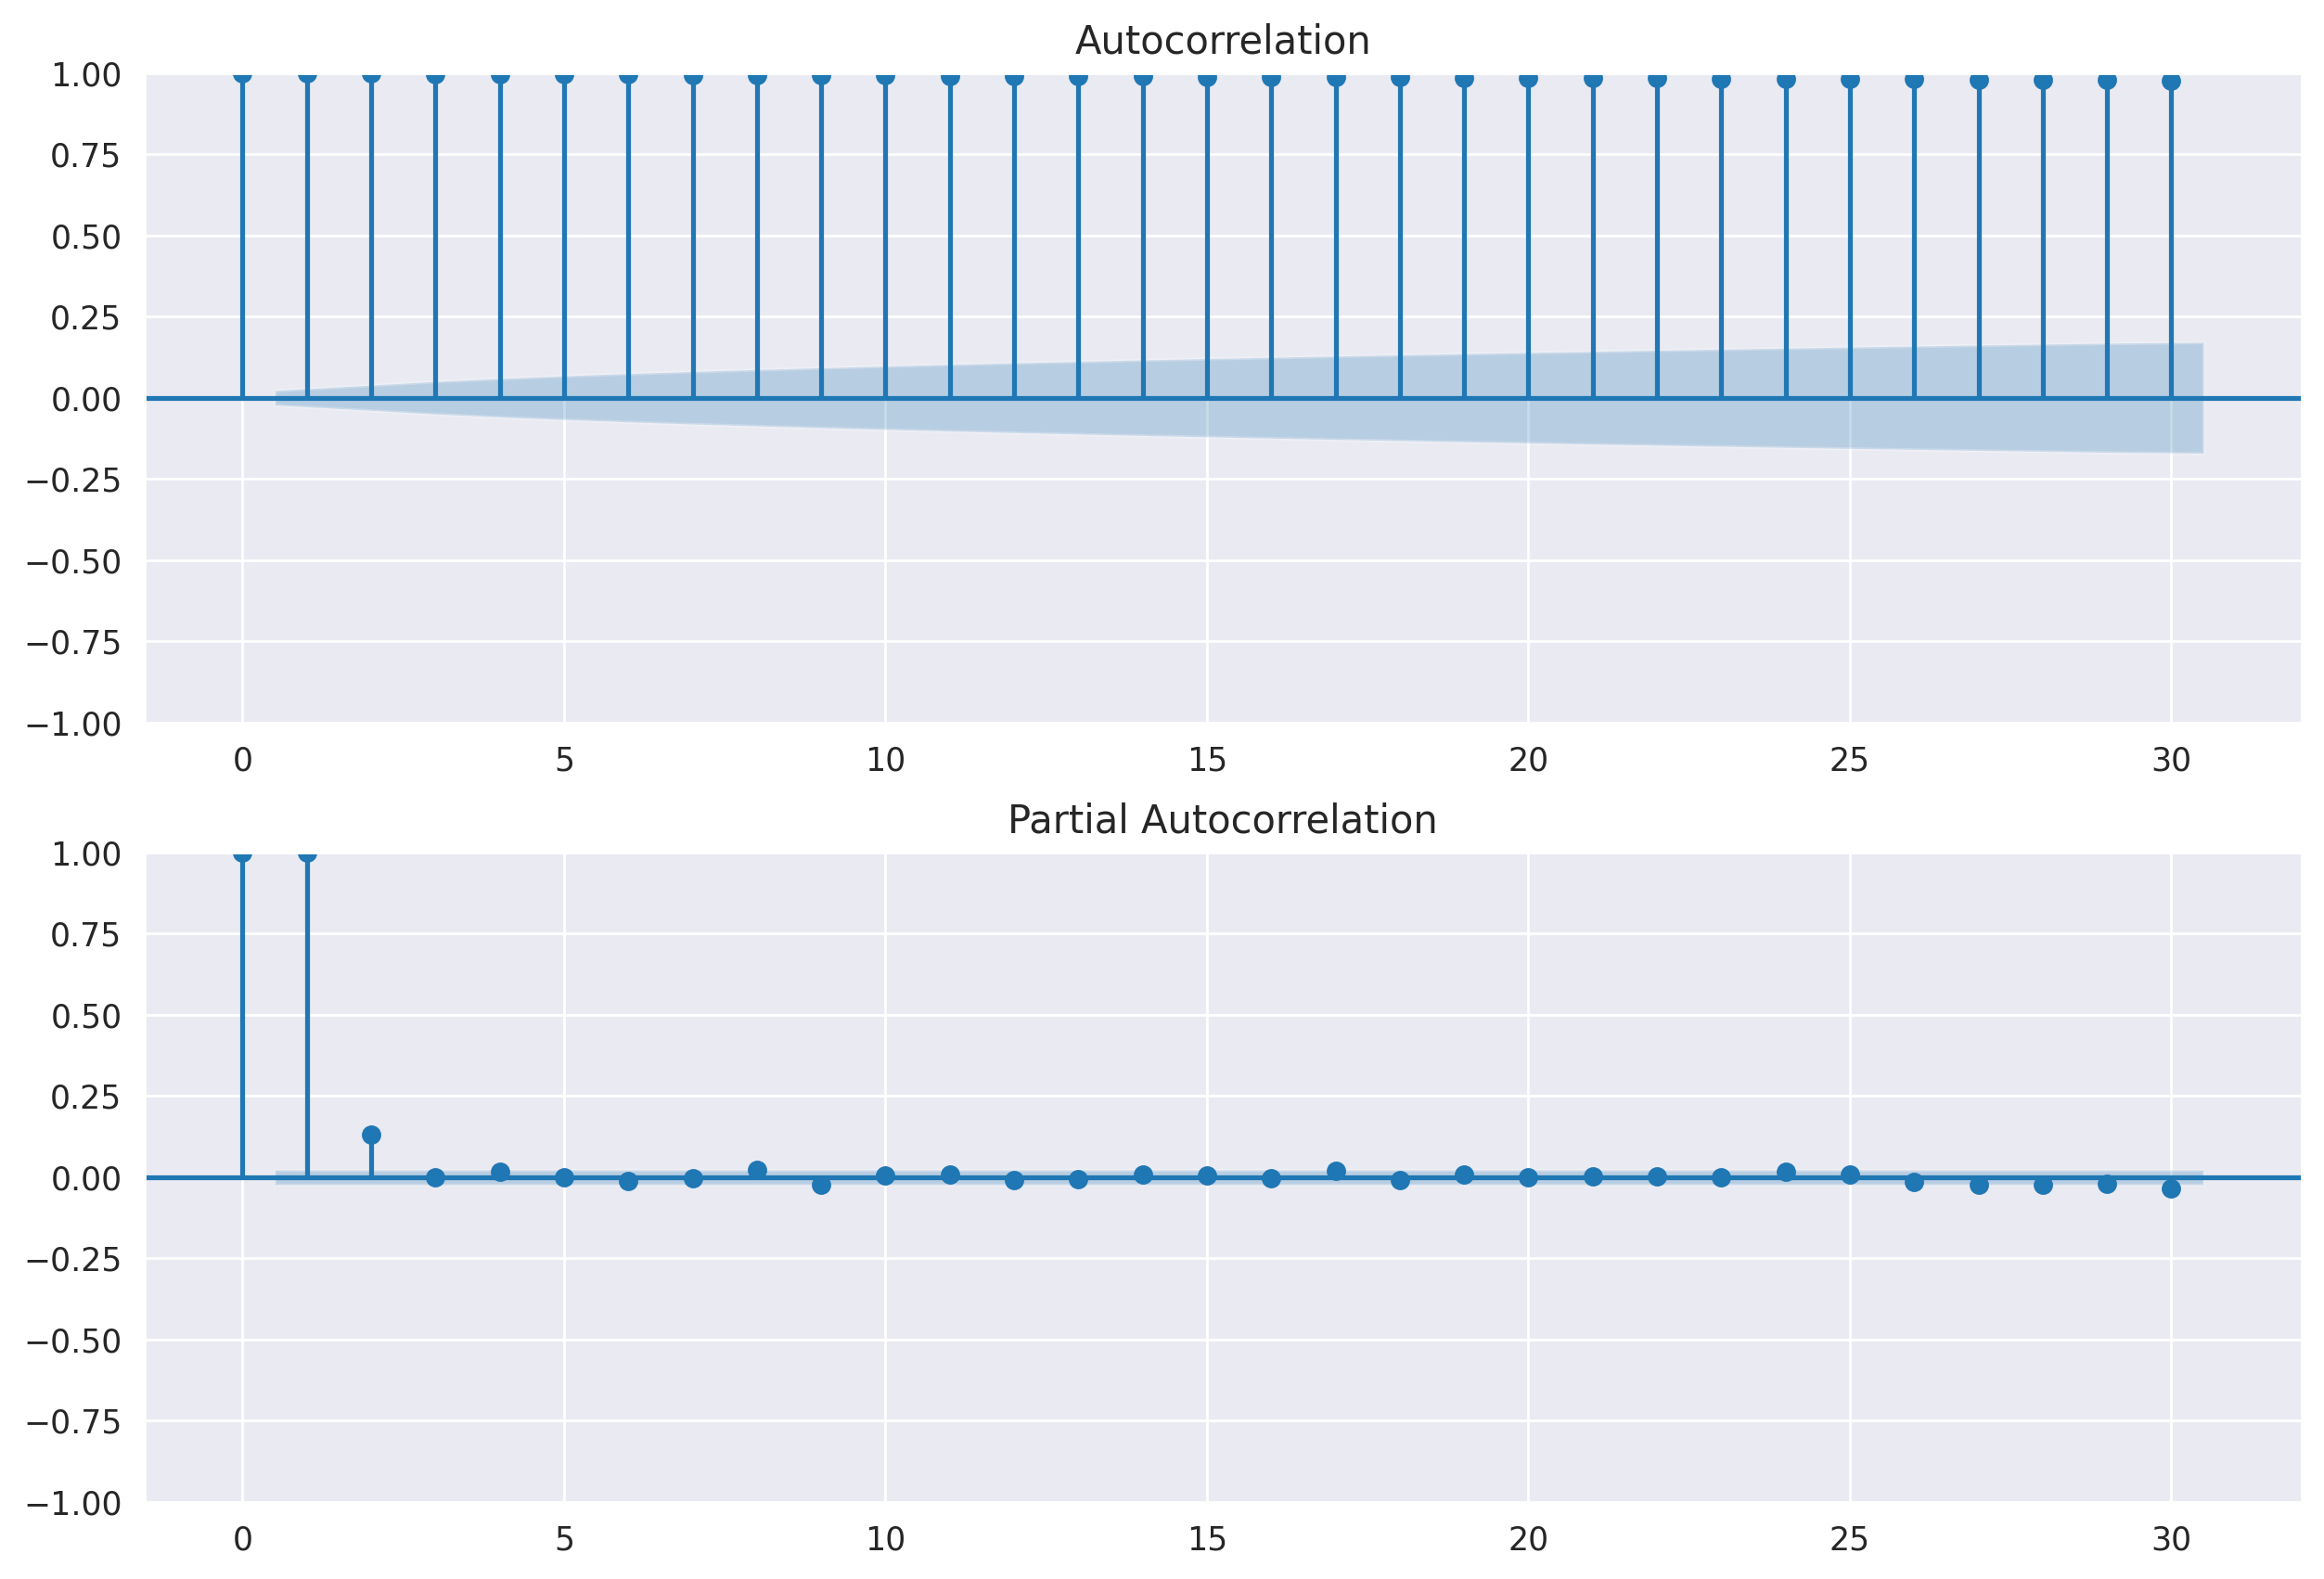

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# this will get us p,d,q values
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Ex_rate'], ax=axes[0], lags=30)
plot_pacf(df['Ex_rate'], ax=axes[1], lags=30)
plt.show()

##Model Fitting

In [82]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Ex_rate'], order=(1, 0, 1))  # Replacing p, d, q with observed values
model_fit = model.fit()

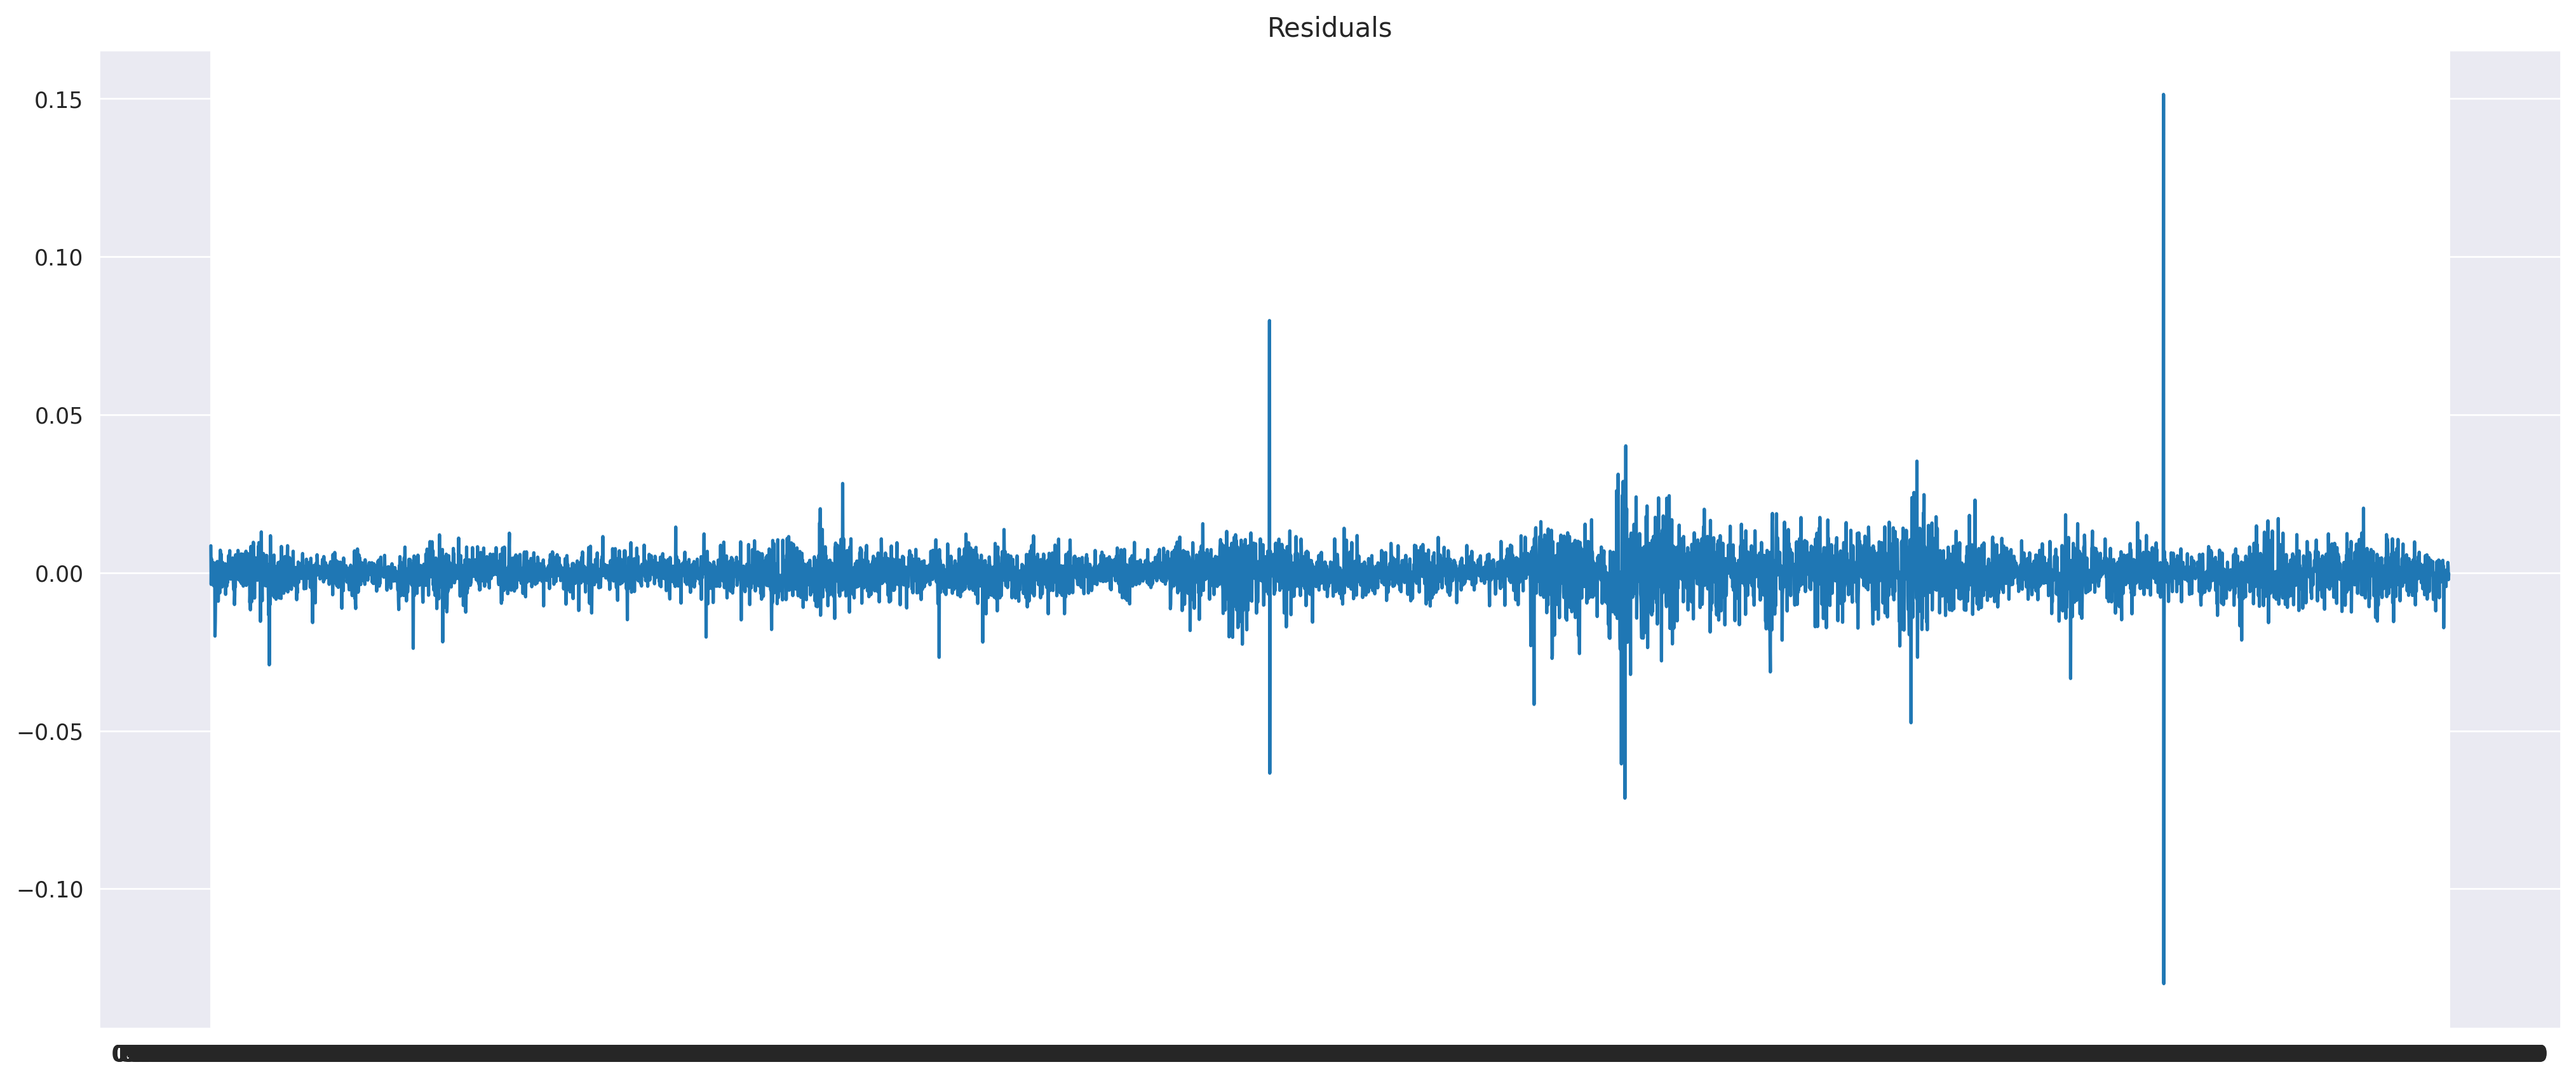

      lb_stat  lb_pvalue
10  12.723581    0.23954


In [83]:
# Analyze residuals
residuals = model_fit.resid
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Perform statistical tests on residuals (e.g., Ljung-Box test)
from statsmodels.stats.diagnostic import acorr_ljungbox
ljungbox_results = acorr_ljungbox(residuals, lags=[10])  # Adjust lags as needed
print(ljungbox_results)

These values indicate the probability of observing the calculated test statistic (or a more extreme value) if there were truly no autocorrelation in the residuals.

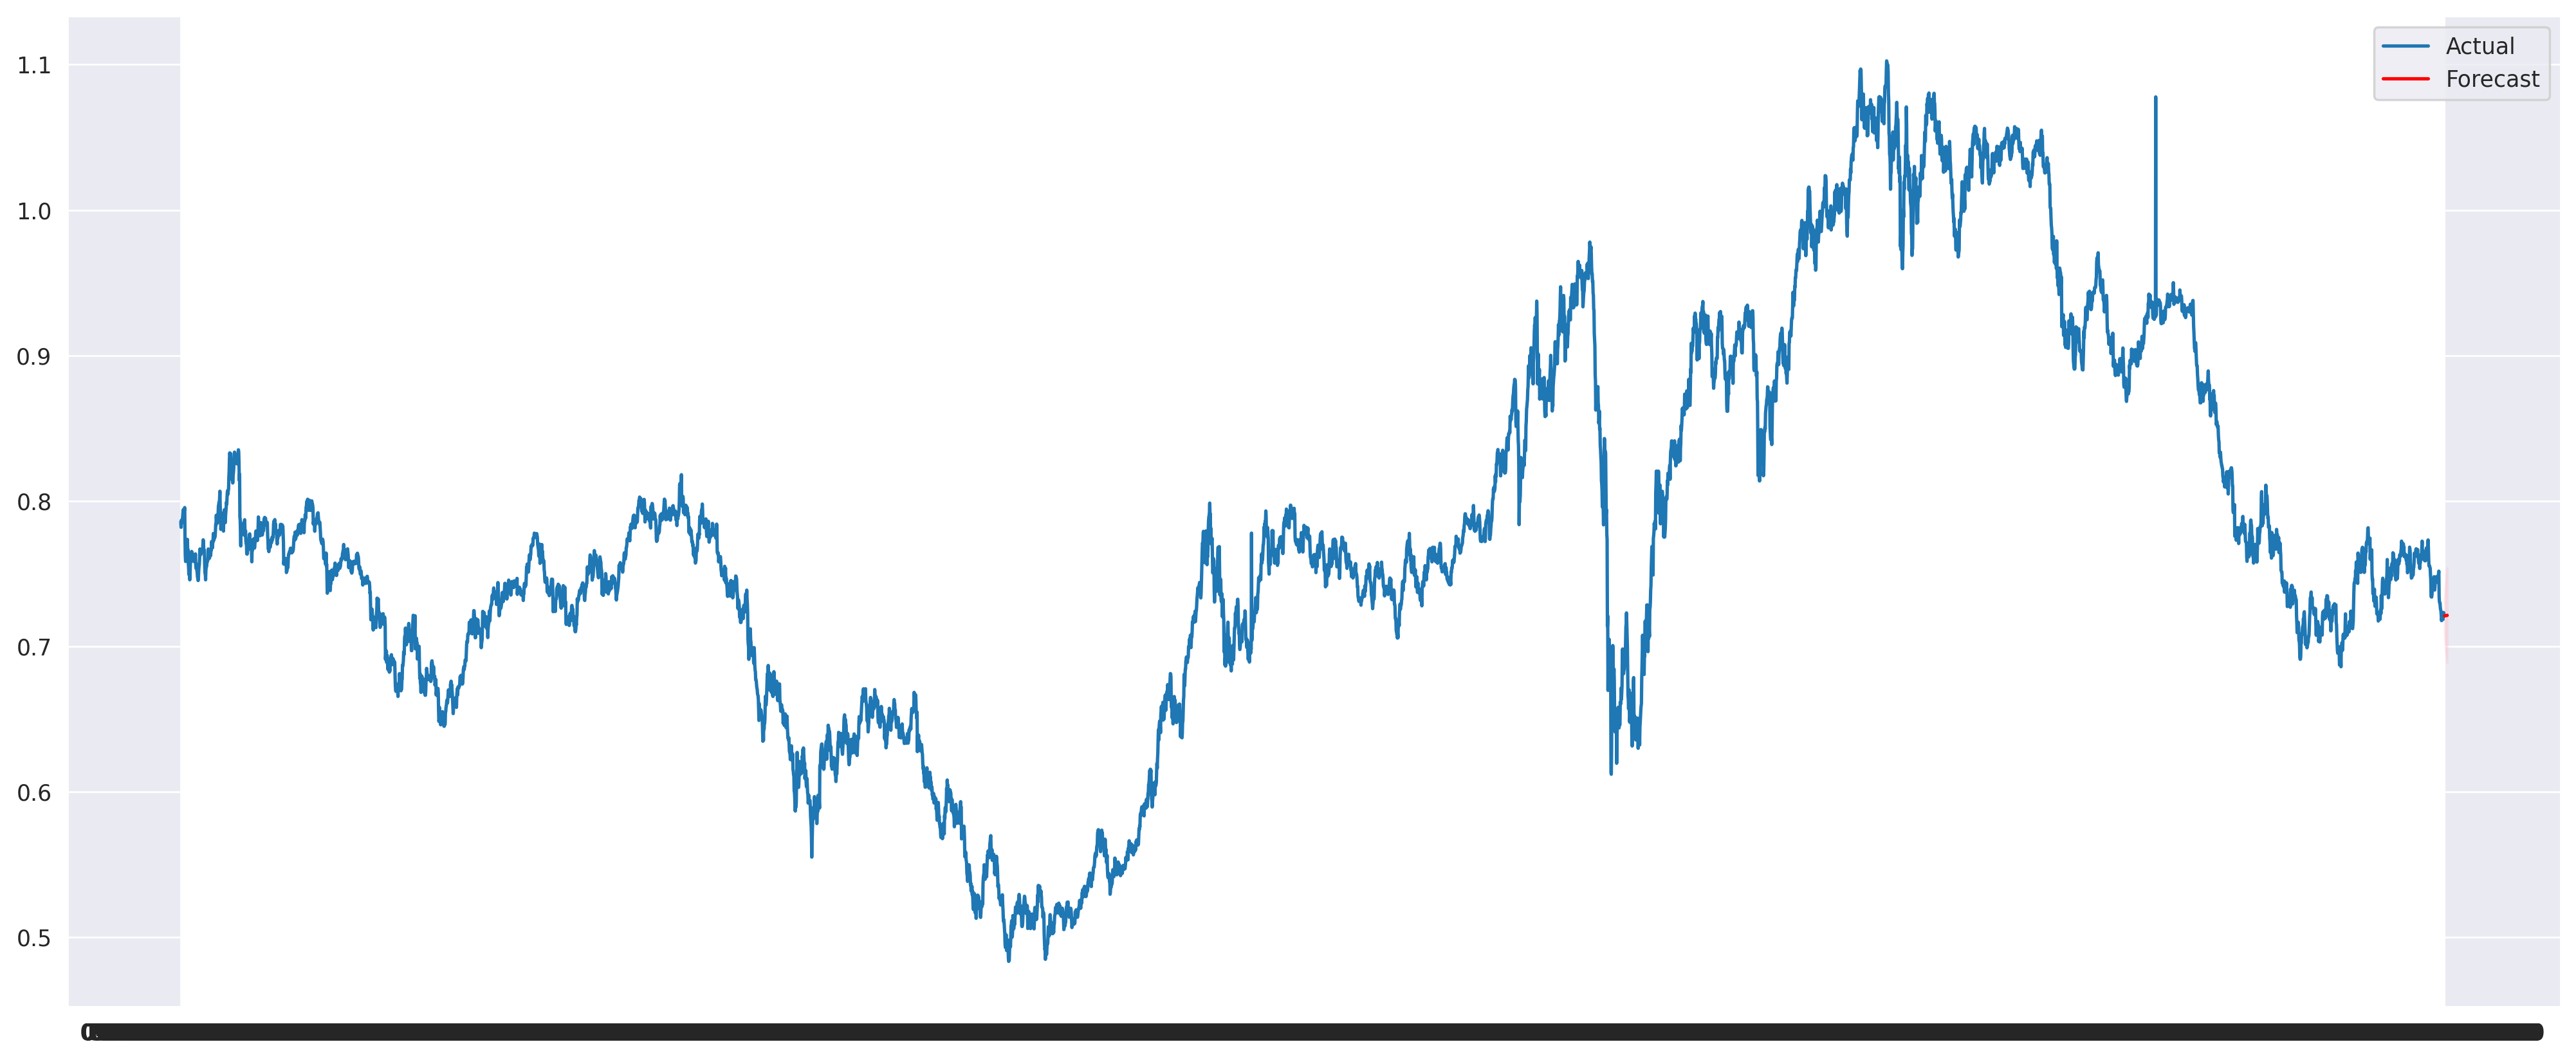

In [84]:
# Forecast future values
forecast = model_fit.get_forecast(steps=10)  # Forecast 10 steps ahead
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot actual vs. forecasted values
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

# model-building - Exponential smoothing

In [106]:
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error

# Define parameter ranges for grid search
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
beta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

best_mse = float('inf')
best_alpha = None
best_beta = None

# Grid search
for alpha in alpha_values:
    for beta in beta_values:
        model = Holt(df['Ex_rate'], initialization_method="estimated").fit(smoothing_level=alpha, smoothing_slope=beta)
        forecast = model.forecast(steps=10)  # Adjust steps as needed
        mse = mean_squared_error(df['Ex_rate'][-10:], forecast)  # Evaluate on last 10 data points
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha
            best_beta = beta

print(f"Best alpha: {best_alpha}, Best beta: {best_beta}, Best MSE: {best_mse}")

Best alpha: 0.3, Best beta: 0.2, Best MSE: 2.557278549720755e-06


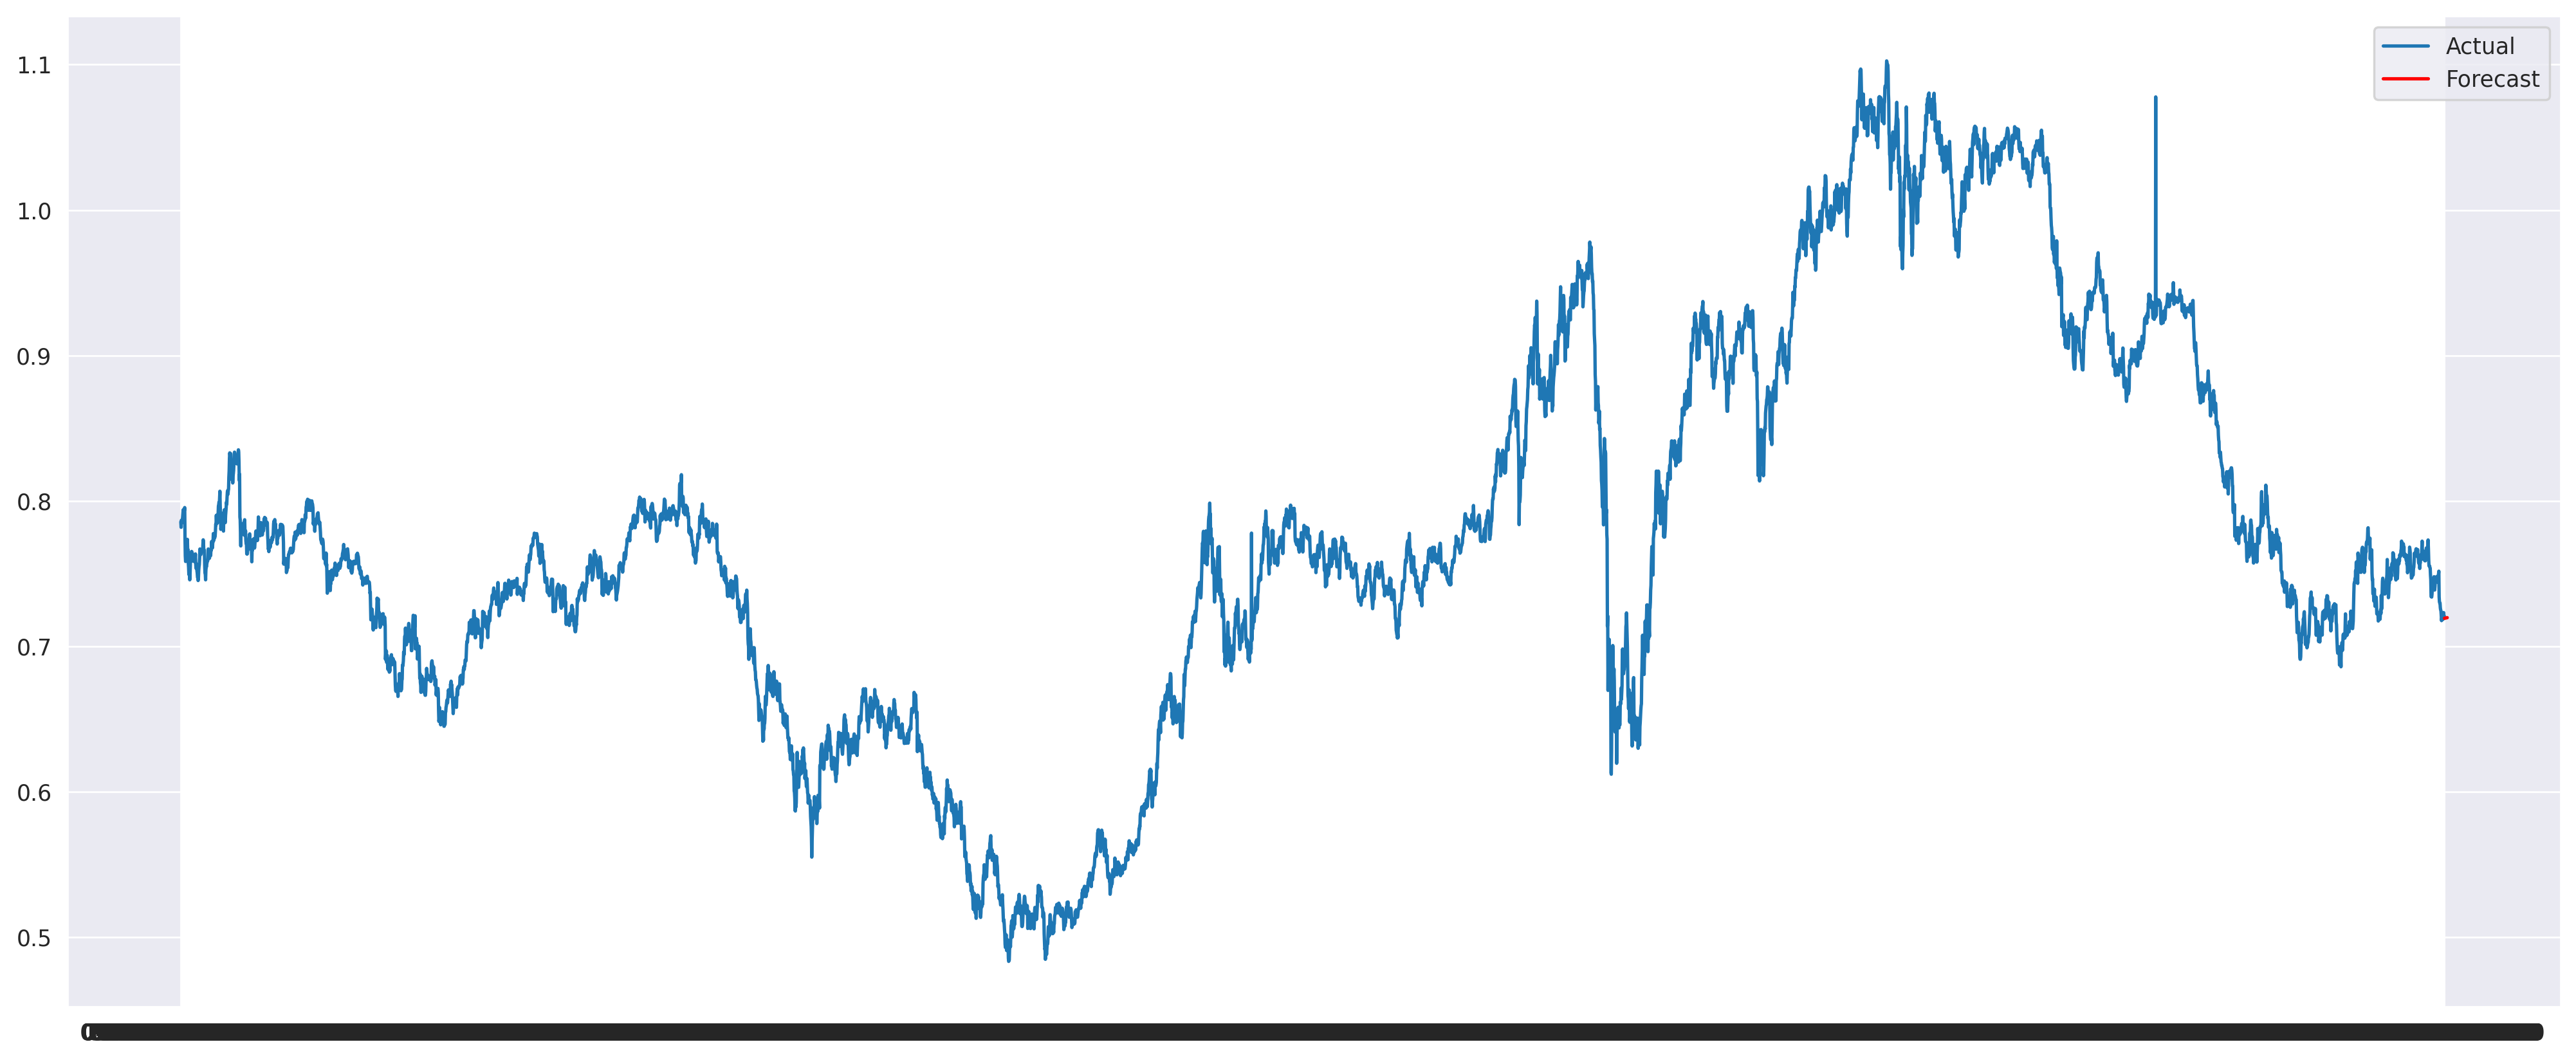

In [107]:
# Fit the model with best parameters
best_model = Holt(df['Ex_rate'], initialization_method="estimated").fit(smoothing_level=best_alpha, smoothing_slope=best_beta)

# Forecast
forecast = best_model.forecast(steps=10)

# Plot actual vs. forecasted values
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

In [111]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

actual_values = df['Ex_rate'][-10:]
# Get ARIMA forecast values
arima_forecast = forecast_mean  # From your ARIMA code
arima_mae = mean_absolute_error(actual_values, arima_forecast)
arima_rmse = mean_squared_error(actual_values, arima_forecast, squared=False)
arima_mape = mean_absolute_percentage_error(actual_values, arima_forecast) * 100

In [112]:
# Get Exponential Smoothing forecast values
exp_smoothing_forecast = forecast  # From your Exponential Smoothing code
exp_smoothing_mae = mean_absolute_error(actual_values, exp_smoothing_forecast)
exp_smoothing_rmse = mean_squared_error(actual_values, exp_smoothing_forecast, squared=False)
exp_smoothing_mape = mean_absolute_percentage_error(actual_values, exp_smoothing_forecast) * 100  # Note the multiplication by 100 for percentage

In [113]:
print("ARIMA - MAE:", arima_mae)
print("ARIMA - RMSE:", arima_rmse)
print("ARIMA - MAPE:", arima_mape)

print("Exponential Smoothing - MAE:", exp_smoothing_mae)
print("Exponential Smoothing - RMSE:", exp_smoothing_rmse)
print("Exponential Smoothing - MAPE:", exp_smoothing_mape)


ARIMA - MAE: 0.0016820264291765308
ARIMA - RMSE: 0.001915363304824771
ARIMA - MAPE: 23.381088490237325
Exponential Smoothing - MAE: 0.0012349022675599564
Exponential Smoothing - RMSE: 0.0015991493206454345
Exponential Smoothing - MAPE: 17.13012131691961


##Model Comparison
If ARIMA performed better: It indicates that your exchange rate data has complex patterns that ARIMA was able to capture effectively.

If Exponential Smoothing performed better: It suggests that the recent changes and trends in your data were better captured by the adaptive nature of Exponential Smoothing.

If performance was similar: Consider other factors like model simplicity and interpretability to make a choice. You might also explore other forecasting techniques.


#Conclusion
Based on the comparison, you can conclude which model is more suitable for forecasting exchange rates for your specific data.